# Compute species prevalence score

<ipython-input-19-4fc78e911afb>:26: RuntimeWarning: divide by zero encountered in log10
  df_bac_log = np.log10(df_bac)


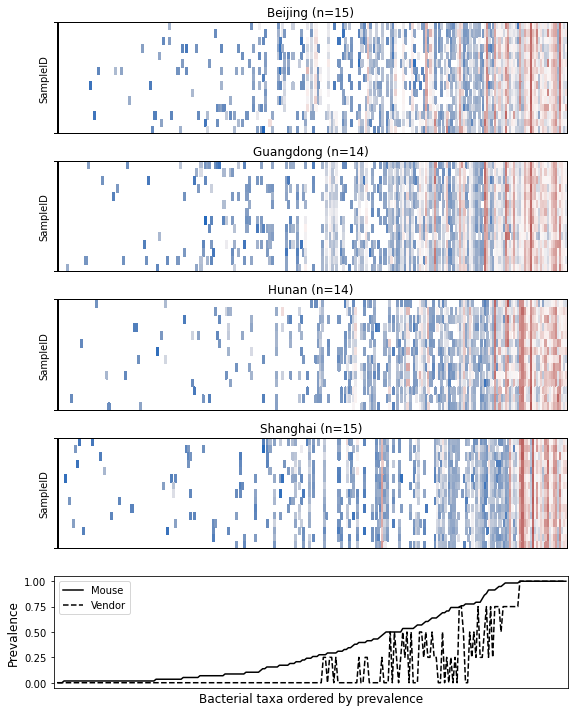

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy

# read meta data
df_meta = pd.read_csv('../../our_data/meta_data.csv', index_col=0)
df_meta = df_meta[df_meta.Day == 0] # baseline microbiota

# read bacterial abundance (phenotype)
df_bac = pd.read_csv('../../our_data/16S_relative_abundance_species.csv', index_col=0)
df_bac = df_bac.loc[df_meta.index]

# remove species that are not present in all baseline
df_bac = df_bac.loc[:, (df_bac != 0).any(axis=0)]
df_bac_mask = (df_bac >= 1e-5).astype(int) # add mask (1 represents presence)

# compute prevalence score in mice and sort bacterial taxa based on the score
df_bac_mask_T = deepcopy(df_bac_mask.T)
df_bac_mask_T['mean'] = df_bac_mask_T.mean(axis=1)
df_bac_mask_T = df_bac_mask_T.sort_values('mean')
df_prevalence_mice = df_bac_mask_T[['mean']].rename({'mean':'prevalence'}, axis=1)
df_bac_mask = df_bac_mask_T.drop('mean', axis=1).T
df_bac = df_bac.loc[df_bac_mask.index, df_bac_mask.columns]
df_bac_log = np.log10(df_bac)

# prevalence in vendor (at least one sample)
df_bac_mask_vendor = pd.merge(df_bac_mask, df_meta[['Vendor']], left_index=True, right_index=True, how='left').groupby('Vendor').agg('mean')
df_bac_mask_vendor = (df_bac_mask_vendor>0.001).astype(int)
df_bac_mask_vendor_T = df_bac_mask_vendor.T
df_prevalence_vendor_loose = df_bac_mask_vendor_T.mean(axis=1).to_frame().rename({0:'prevalence'},axis=1)

# prevalence in vendor (all samples)
df_bac_mask_vendor = pd.merge(df_bac_mask, df_meta[['Vendor']], left_index=True, right_index=True, how='left').groupby('Vendor').agg('mean')
df_bac_mask_vendor = (df_bac_mask_vendor>0.999).astype(int)
df_bac_mask_vendor_T = df_bac_mask_vendor.T
df_prevalence_vendor_stringent = df_bac_mask_vendor_T.mean(axis=1).to_frame().rename({0:'prevalence'},axis=1)

# plot heatmap
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(8,10), sharex=True)
for k,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
    sample_indices = list(df_meta[df_meta.Vendor==vendor].index)
    _ = sns.heatmap(df_bac_log.loc[sample_indices], 
                    ax=ax[k], 
                    cbar=False, 
                    xticklabels=[],
                    yticklabels=[],
                    cmap="vlag",
                    mask=(df_bac_mask^1).loc[sample_indices],
                    vmin=-5,
                    vmax=0
                   )
    _ = ax[k].set_title('%s (n=%d)'%(vendor, len(sample_indices)))
    _ = ax[k].tick_params(left=False, bottom=False)
    
    # Drawing the frame
    ax[k].axhline(y = 0, color='k',linewidth = 2)
    ax[k].axhline(y = df_bac_log.loc[sample_indices].shape[0], color = 'k', linewidth = 2)
    ax[k].axvline(x = 0, color = 'k', linewidth = 2)
    ax[k].axvline(x = df_bac_log.loc[sample_indices].shape[1], color = 'k', linewidth = 2)
    
_ = ax[4].plot(df_prevalence_mice, 'k-', label='Mouse')
_ = ax[4].plot(df_prevalence_vendor, 'k--', label='Vendor')
_ = ax[4].legend()
_ = ax[4].set_xlim([-2,len(df_prevalence_mice.index)])
_ = ax[4].set_xticks([])
_ = ax[4].set_xticklabels([])
_ = ax[4].tick_params(bottom=False)
_ = ax[4].set_ylabel('Prevalence', fontsize=12)
_ = ax[4].set_xlabel('Bacterial taxa ordered by prevalence', fontsize=12)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("baseline_presence_absence_analysis.svg", format="svg")

# Percent of taxa that are absent in at least one mice and at least one vendor

In [18]:
print("%2.2f taxa are absent in at least one mice"%(len(df_prevalence_mice[df_prevalence_mice.prevalence<0.999])/len(df_prevalence_mice)*100))

90.57 taxa are absent in at least one mice


In [21]:
print("%2.2f taxa are absent in at least one vendor"%(len(df_prevalence_vendor_loose[df_prevalence_vendor_loose.prevalence<0.999])/len(df_prevalence_vendor_loose)*100))

64.75 taxa are absent in at least one vendor


# Save prevalence scores to file

In [20]:
df_prevalence = pd.merge(df_prevalence_mice, df_prevalence_vendor_stringent, left_index=True, right_index=True, how='left')
df_prevalence = pd.merge(df_prevalence, df_prevalence_vendor_loose, left_index=True, right_index=True, how='left')
df_prevalence.columns = ['Mouse','Vendor_stringent','Vendor_loose']
df_prevalence.to_csv('baseline_microbiota_prevalence_score_inulin.csv')

df_prevalence.head()

,Mouse,Vendor_stringent,Vendor_loose
Lachnospiraceae-bacterium-3-2,0.000000,0.0,0.00
Bacteroides-sp.-Smarlab-3302398,0.000000,0.0,0.00
Turicimonas-muris,0.000000,0.0,0.00
Rikenellaceae-bacterium-DTU002,0.017241,0.0,0.25
Clostridium-sp.-Clone-49,0.017241,0.0,0.25
